# 0.0 Imports

## 0.0. Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
import datetime
sns.set(rc = {'figure.figsize':(15,8)})
from tabulate import tabulate
from matplotlib import gridspec
from scipy import stats as ss
import random
#para ignorar os alertas futuros
import warnings
warnings.filterwarnings('ignore')

#feacture selection
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

#ml modeling LINEAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor


## 0.1. Helper Functions

In [2]:
# configurações para facilitar o uso do jupyternotebook
#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    plt.style.use( 'bmh' )
#    plt.rcParams['figure.figsize'] = [25, 12]
#    plt.rcParams['font.size'] = 24
#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    sns.set()

In [3]:
#jupyter_settings()

In [4]:
# usado no cap 6 - Feature Selection
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )   

In [5]:
# usado no cap 7 - ML modelling
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

In [6]:
#usada no crossvalidation
def crossvalidation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        #inicio do validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        #final do valitation é o final do dataset
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = ((k-1)*6*7))
        #final do treino é menor que o início do validation
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & ( x_training['date'] <= validation_end_date)]
        
        if verbose:
            #acompanhamento
            print(k)
            print(validation_start_date)
            print(validation_end_date)
        
        #selecionando
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']
        
        #selecionando
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        #model
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model_name': model_name,
                         'MAE_CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index = [0])
    
    

## 0.2 Loading data

In [7]:
df_sales_raw = pd.read_csv('train.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

In [8]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Data Description

In [9]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [10]:
df1.columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

In [11]:
snakecase = lambda x : inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [12]:
df1

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## 1.2 Data dimensions

In [13]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of cols {}'.format(df1.shape[1]))

Number of rows 1017209
Number of cols 18


## 1.3 Data types

In [14]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [16]:
#competition_distance
# se não tem competidor, podemos supor que está muito longe
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
# se for na, copio a data da loja, pois pode possuir competidor mas a data de abertura não está explicita
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)


#competition_open_since_year
# se for na, copio a data da loja, pois pode possuir competidor mas a data de abertura não está explicita
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)


#promo2_since_week   
#a loja decidiu não parcitipar da segunda promoção, então substituo pela valor da data que ela começou para saber a partir de quando ela caiu fora
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)


#promo2_since_year
#a loja decidiu não parcitipar da segunda promoção, então substituo pela valor da data que ela começou para saber a partir de quando ela caiu fora
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)


#promo_interval
#para identifica os meses que a promo2 tava ativa
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Jun', 9: 'Aug', 10: 'Sep', 11: 'Nov', 12: 'Dez'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)



In [17]:
df1.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## 1.6 Change Types

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

## 1.7.1 Numerical

In [20]:
num_atributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [21]:
#central tendenxy - mean, median
ct1 = pd.DataFrame(num_atributes.apply(np.mean))
ct2 = pd.DataFrame(num_atributes.apply(np.median))

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_atributes.apply(np.std))
d2 = pd.DataFrame(num_atributes.apply(min))
d3 = pd.DataFrame(num_atributes.apply(max))
d4 = pd.DataFrame(num_atributes.apply(lambda x : x.max() - x.min()))
d5 = pd.DataFrame(num_atributes.apply(lambda x : x.skew()))
d6 = pd.DataFrame(num_atributes.apply(lambda x : x.kurtosis()))

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1).reset_index()
m.columns = ['atributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

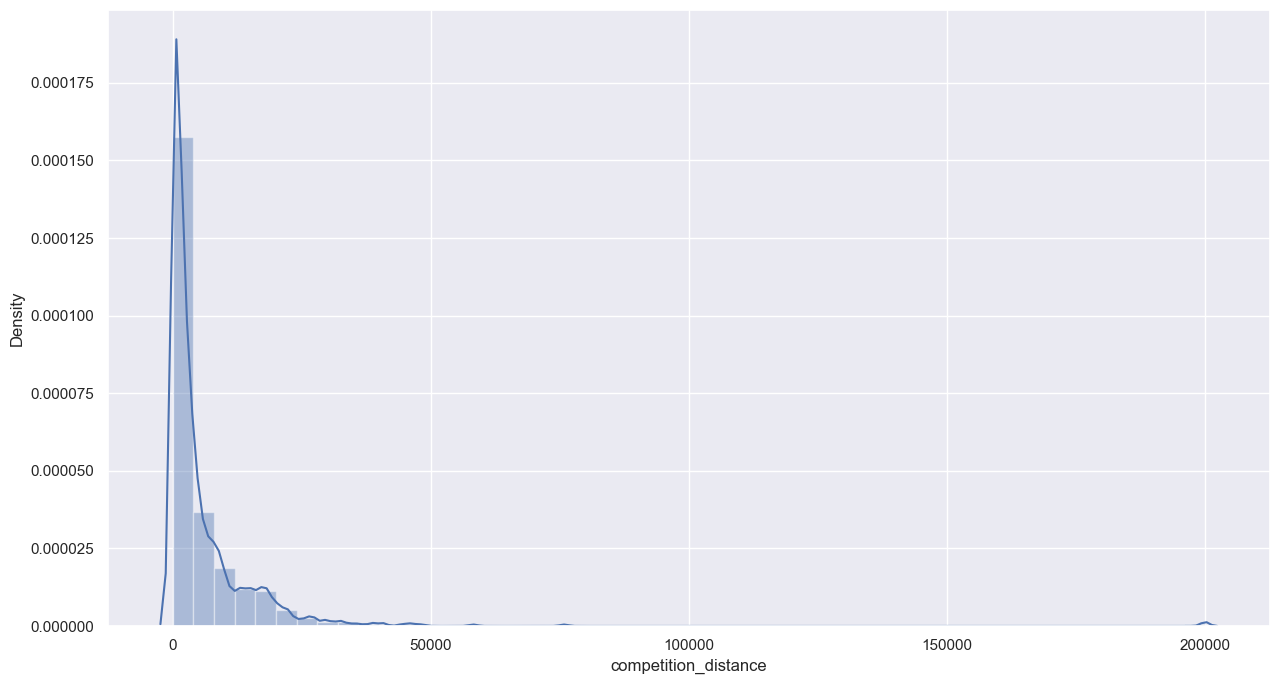

In [22]:
sns.distplot(df1['competition_distance'])

## 1.7.2 Category

In [23]:
cat_atributes.apply(lambda x : x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         11
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

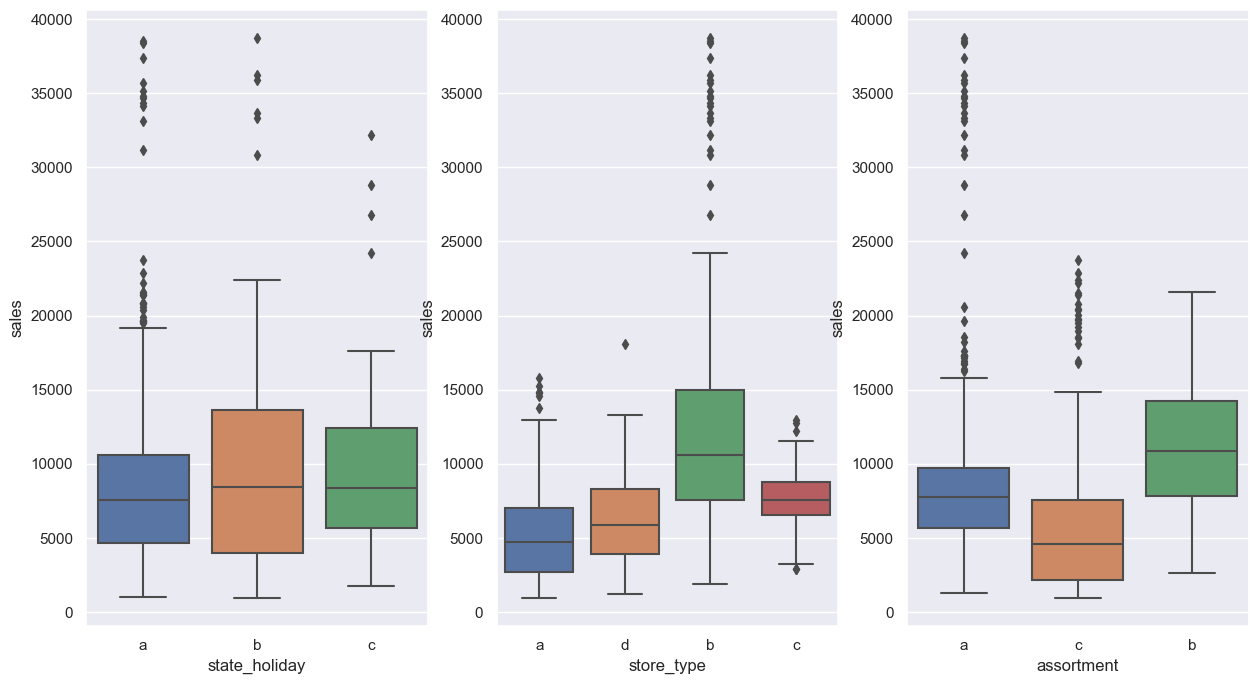

In [24]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2.0 Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1 Mapmind

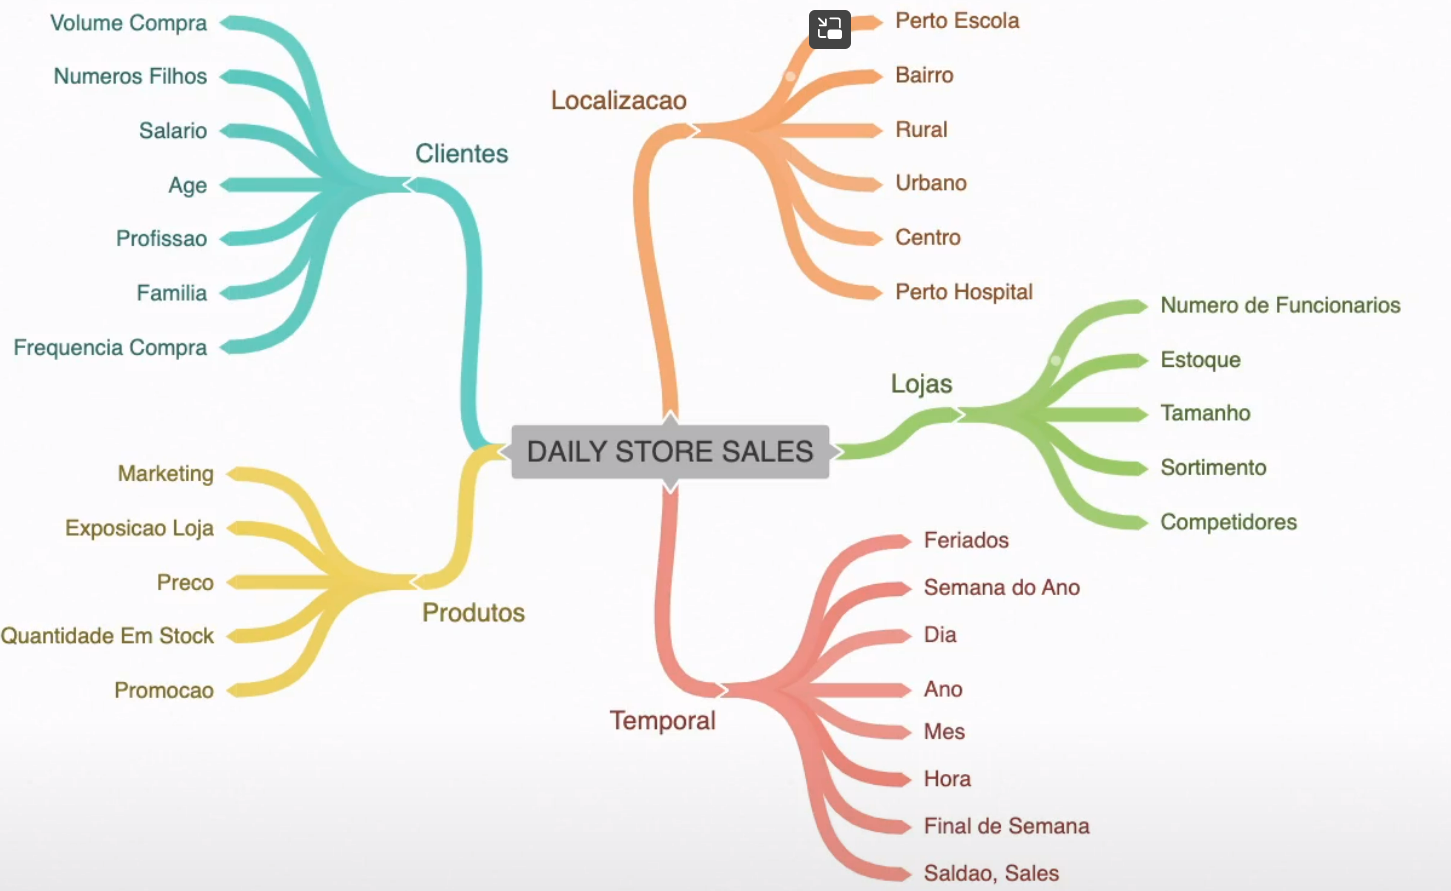

In [26]:
Image('img\mapmind.png')

## 2.2 Lista de Hipóteses

2.2. Criacao das Hipoteses

2.2.1. Hipoteses Loja
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

2.2.2. Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

2.2.3. Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

2.3. Lista Final de Hipóteses
1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Features

In [27]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since month
#juntei o ano com o mês, com isso subtrai com a data, dividi por 30 para deixar em mês, e isolei esse resultado com ox.days
df2['competition_since'] = df2.apply( lambda x : datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

#promo since week
#juntei o ano e a semana do ano como string da promoção, apliquei strptime para adicionar dia e transformar em data, subtrai por 7 para pegar o início da semana, depois dividi por sete na subtração para tirar isolar o resultado com o x.days
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 Variable filterers

In [28]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [29]:
#quando a loja ta fechada não tem venda
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem das colunas

In [30]:
#não saberei quantos clientes terão na loja para ajudar na prediçã no futuro
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis = 1)

In [31]:
df3

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


# 4.0 Exploratore Data Analisys (EDA)

In [32]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales'>

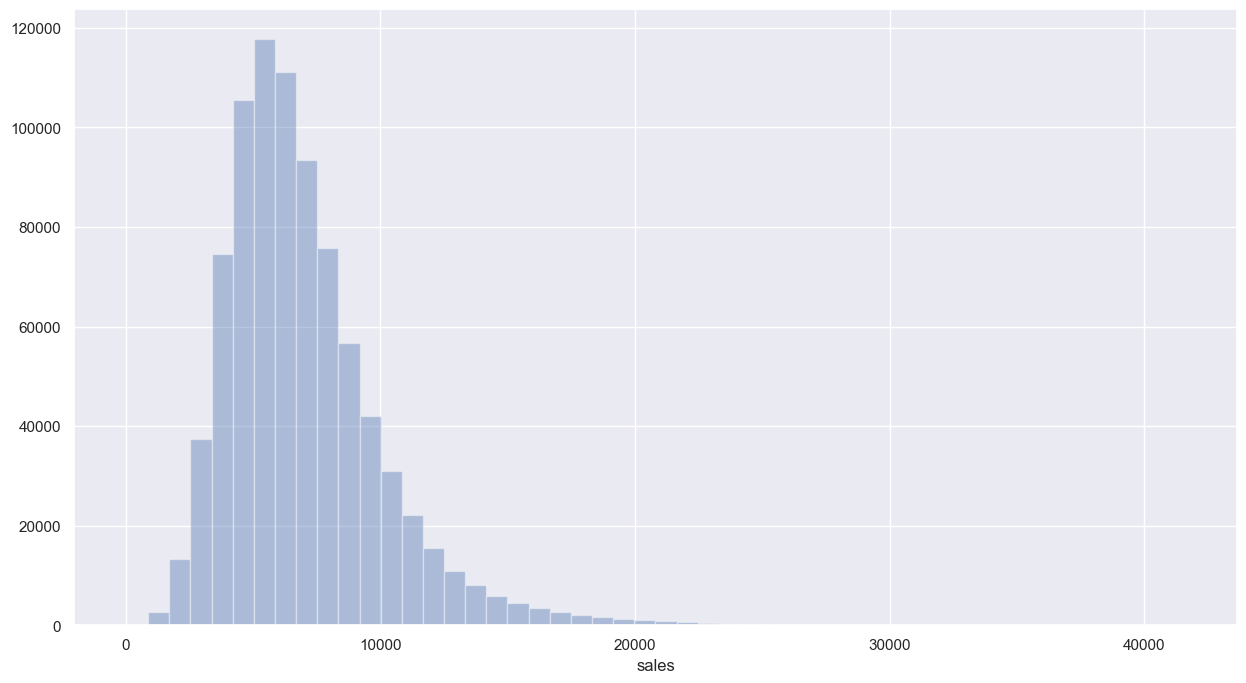

In [33]:
sns.distplot(df4['sales'], kde = False)

### 4.1.2 Numerical Variable

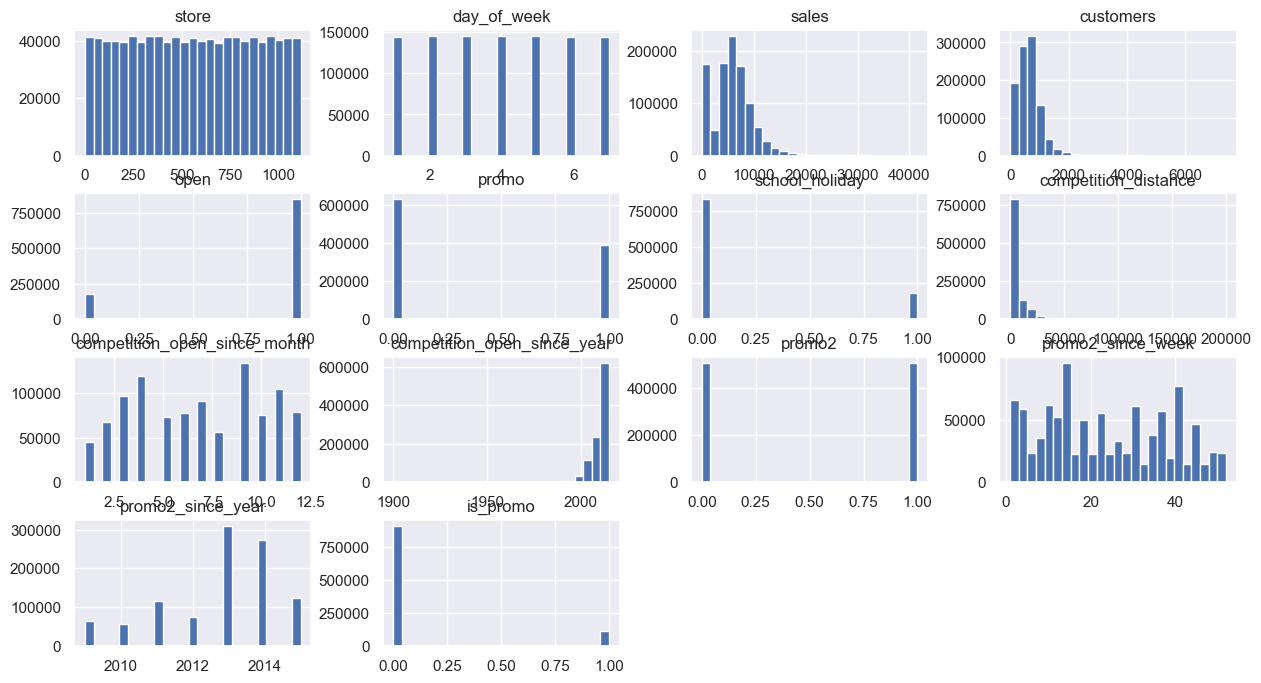

In [34]:
num_atributes.hist(bins = 25);

### 4.1.3 Categorical Variable

In [35]:
cat_atributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

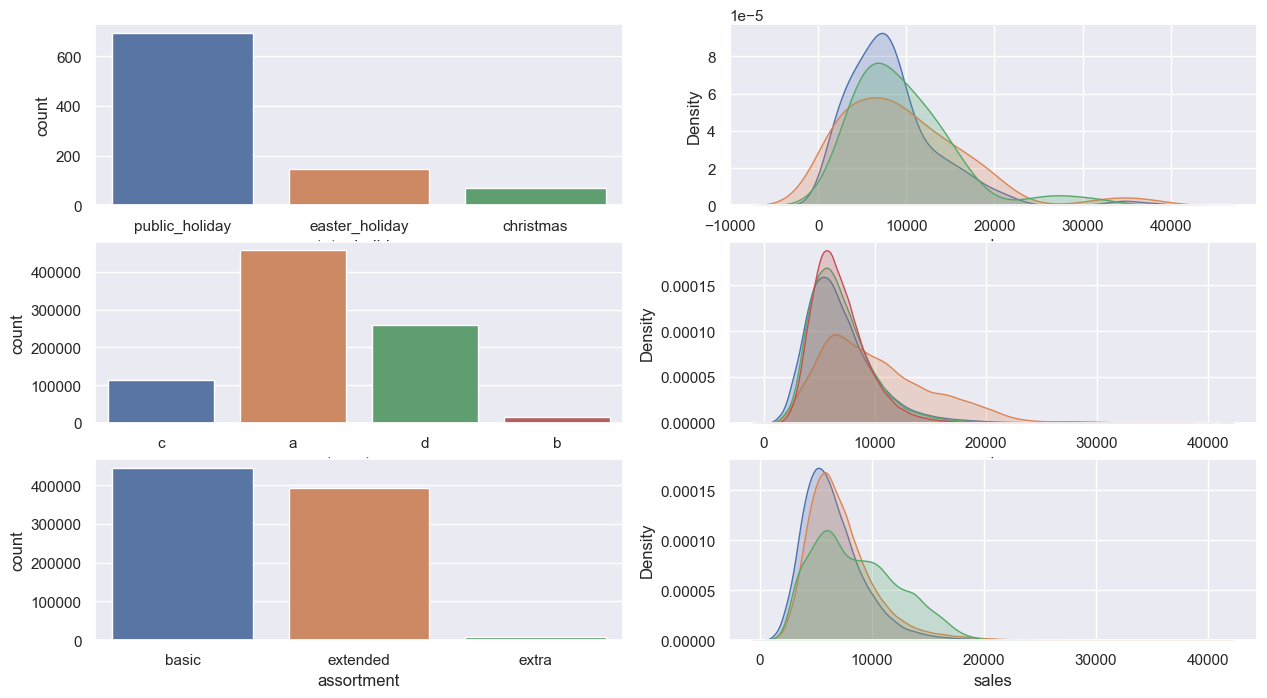

In [37]:
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True);


plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True);


plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True);

## 4.2 Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
#### Falso, lojas com maior sortimento vendem menos.

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


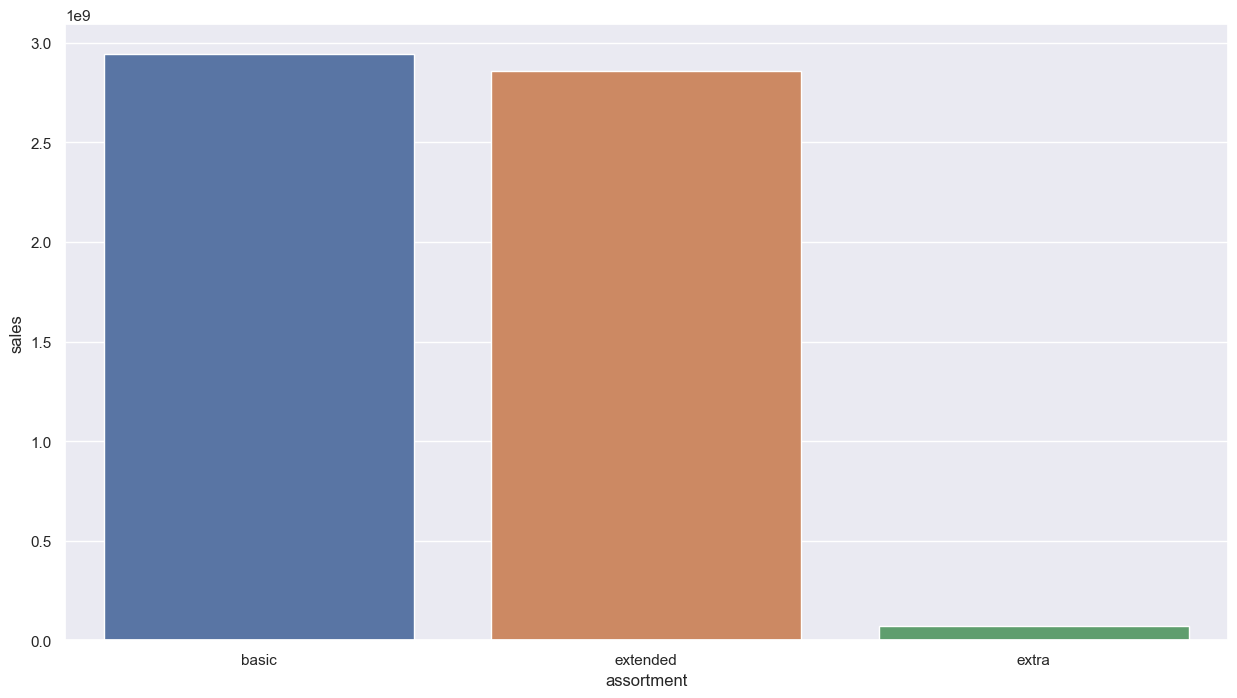

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2

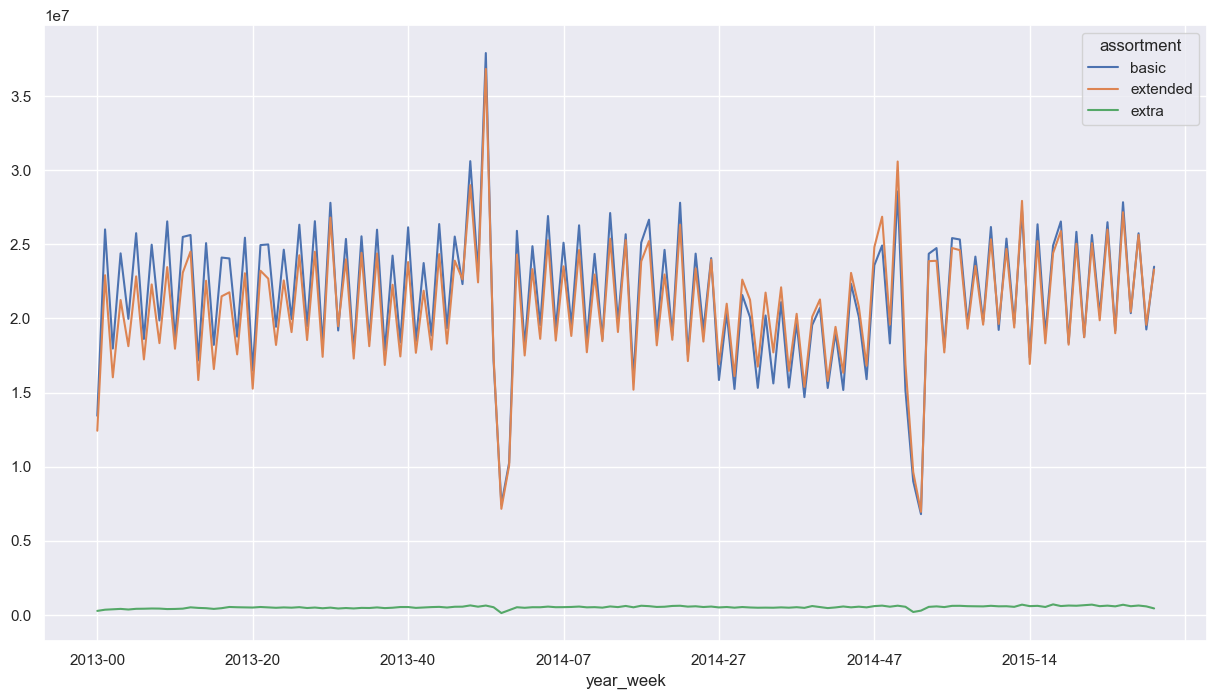

In [39]:
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

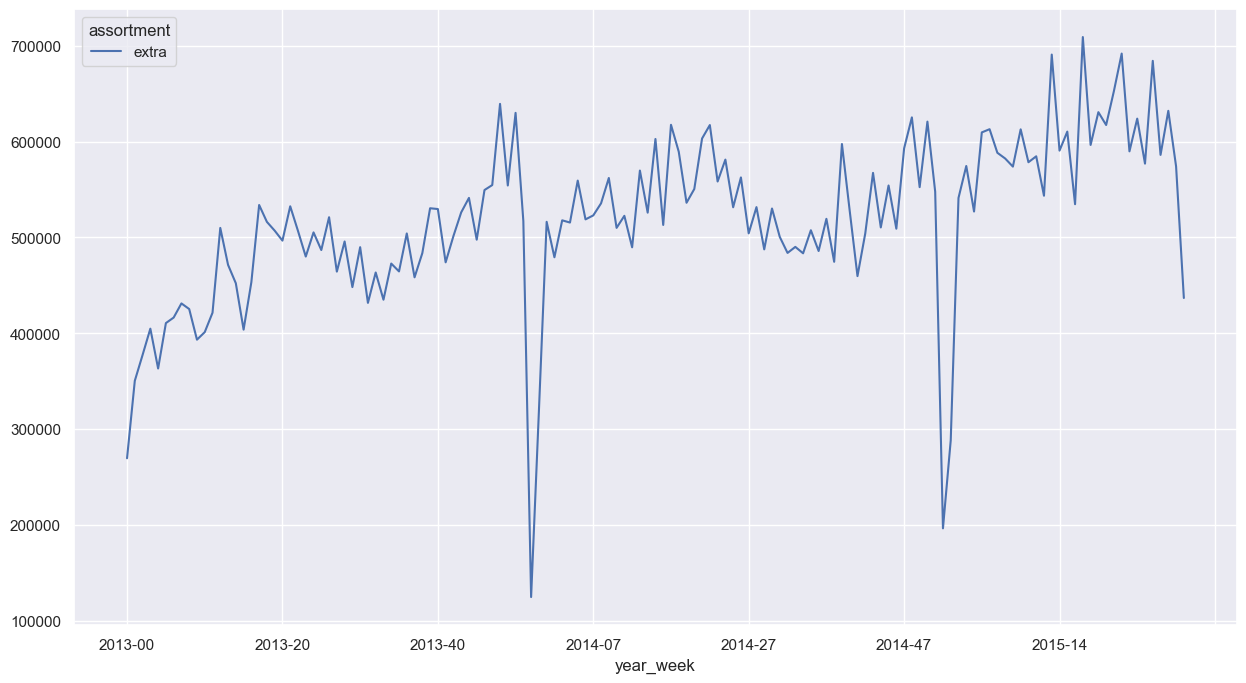

In [40]:
aux3 = df4[df4['assortment'] == 'extra']
aux3 = aux3[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
#### Falço, lojas com competidores mais próximos vendem mais 

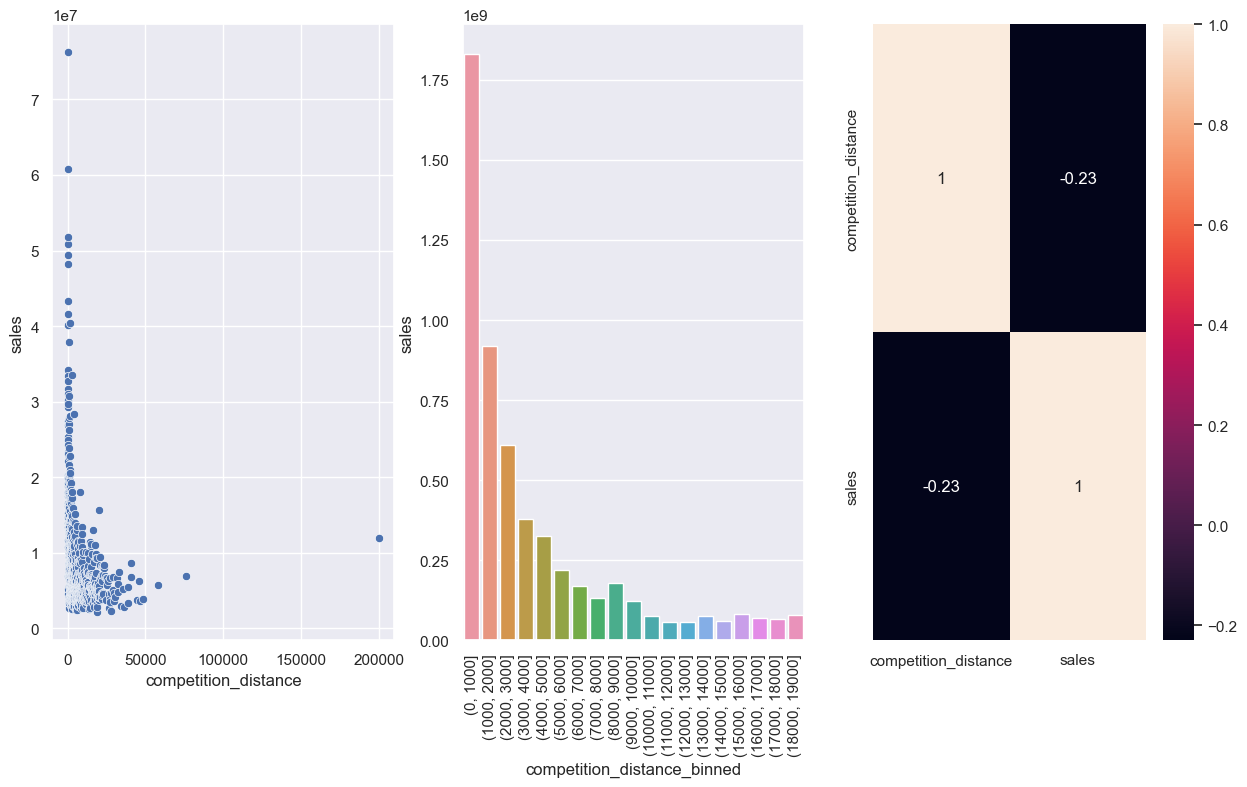

In [41]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);



### H3. Lojas com competidores à mais tempo deveriam vender mais.
#### Falso, pois lojas com competidores a mais tempo vendem menos.
#### Valores negativos informam que um competidor estava previsto para ser aberto, ou seja estavam vendendo muito bem e um competidor surgiu

<AxesSubplot:>

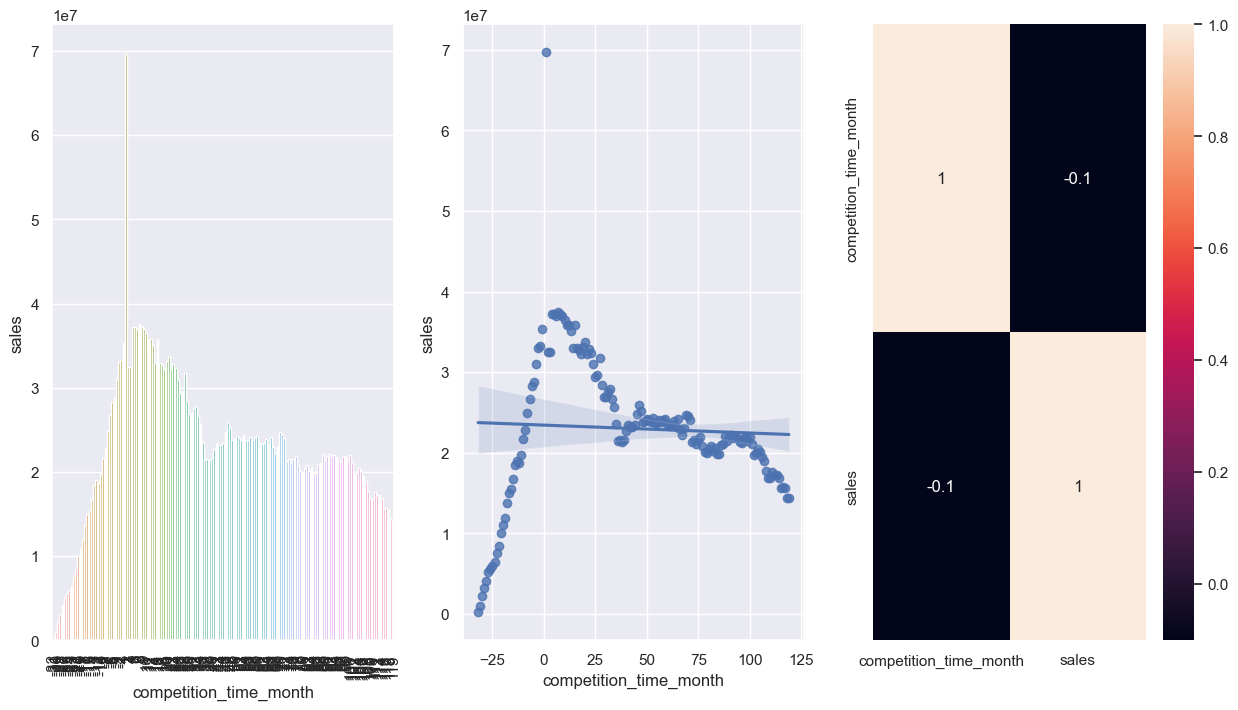

In [42]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

In [43]:
aux1

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527
...,...,...
371,1403,153074
372,1404,155301
373,1405,154513
374,1406,158205


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
#### Falso, lojas com promoçoes ativas por mais tempo vendem menos, depois de certo periodo perde a força.

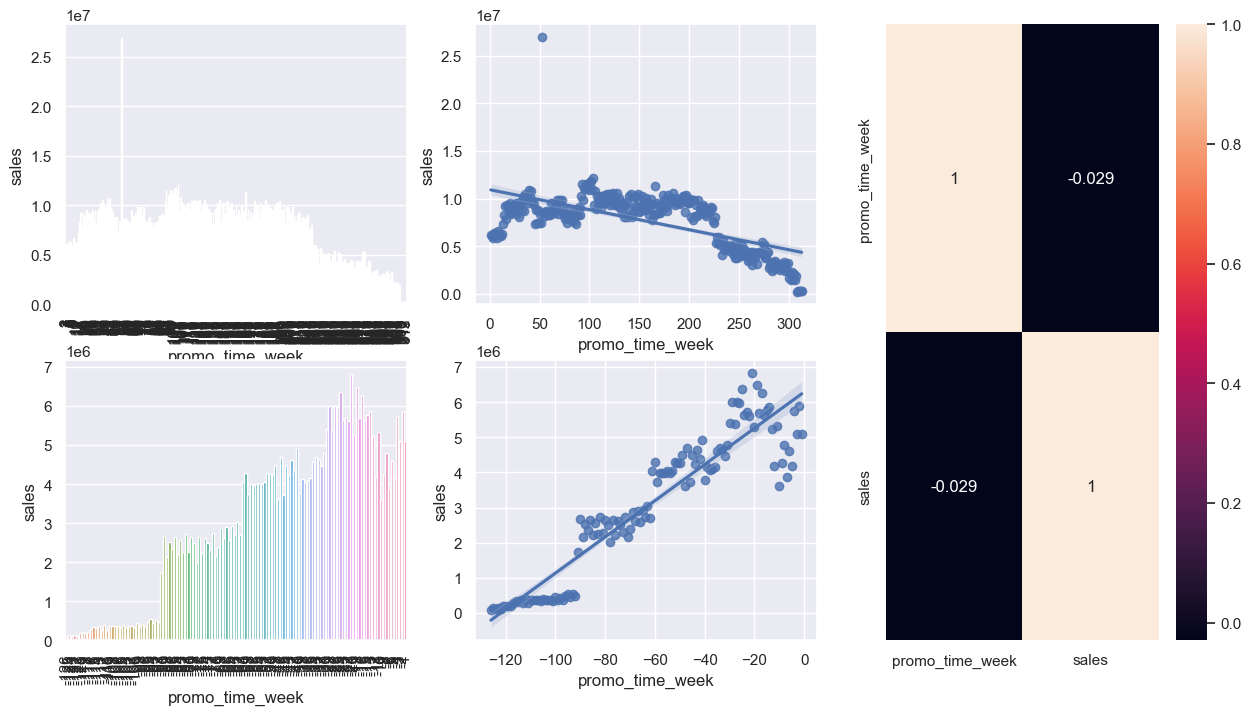

In [44]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

#foi feito um zoom no gráfico promo_time_week versus sales para ver somente promoção regular e depois somente promoção extendida

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### <s>H5. Lojas com mais dias de promoção deveriam vender mais.

### 6. Lojas com mais promoções consecutivas deveriam vender mais.
#### Falso, porque lojas com promoções consecutivas vendem menos.

In [45]:
 df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


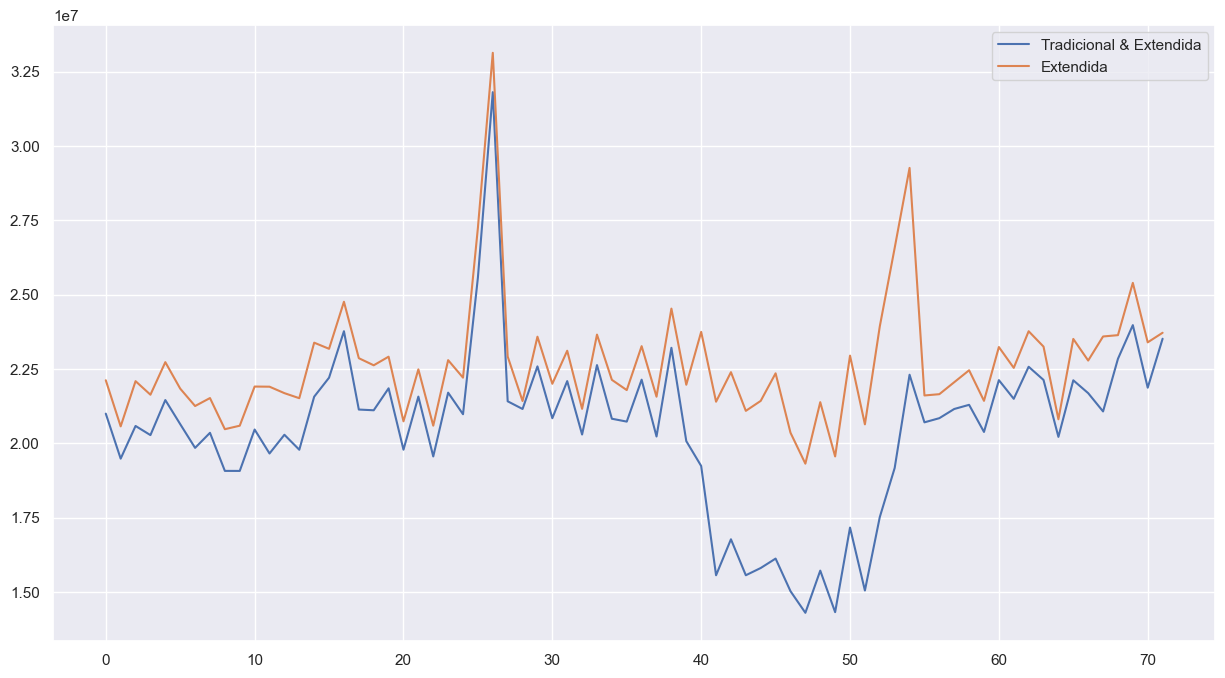

In [46]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


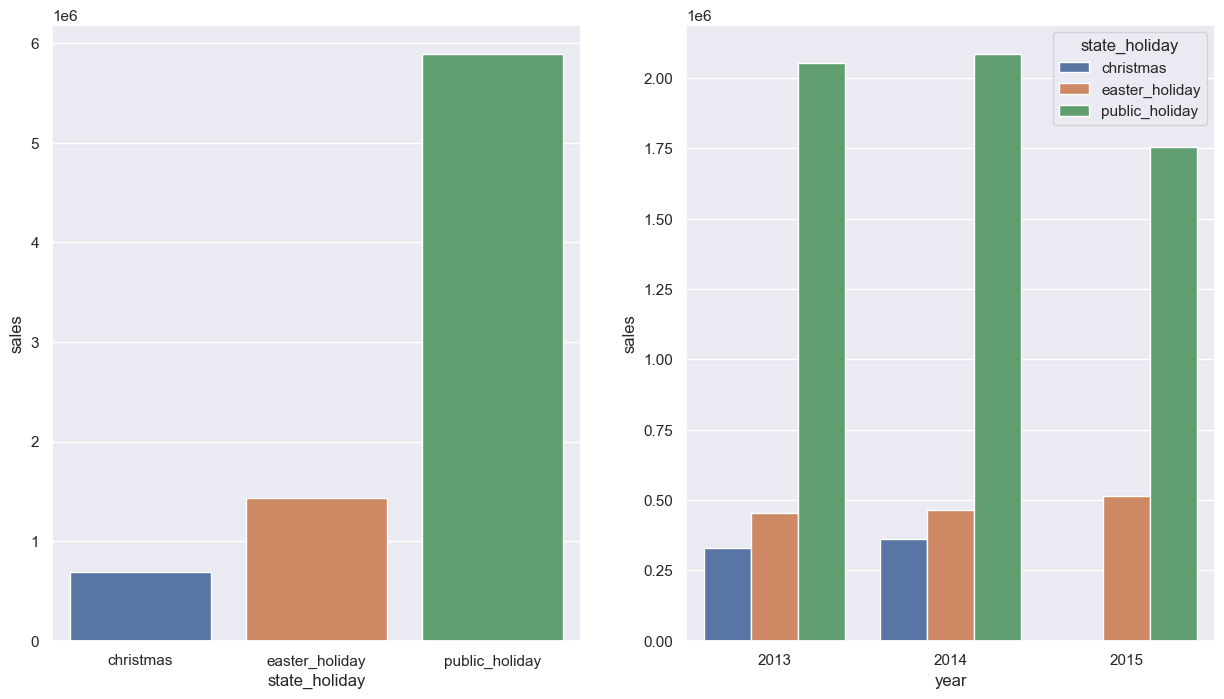

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()

sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 8. Lojas abertas durante o feriado de Natal deveriam vender mais.
#### FALSA Lojas abertas durante o feriado do Natal vendem menos.

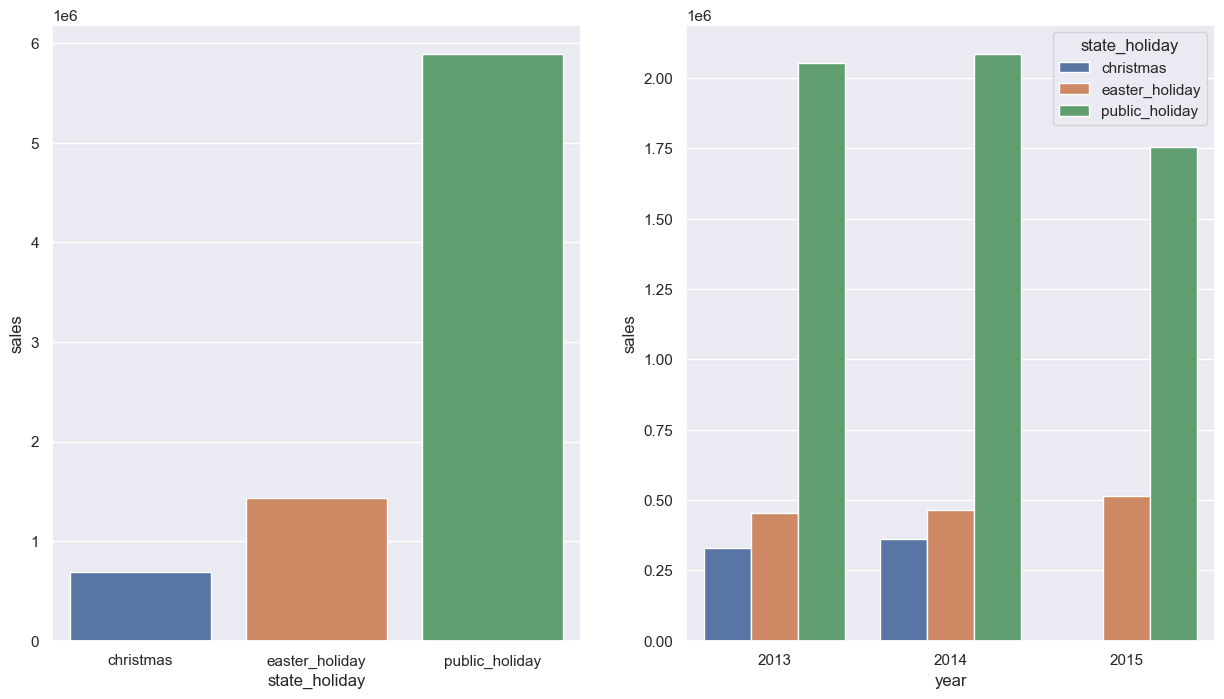

In [48]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 9. Lojas deveriam vender mais ao longo dos anos.
#### FALSA Lojas vendem menos ao longo dos anos

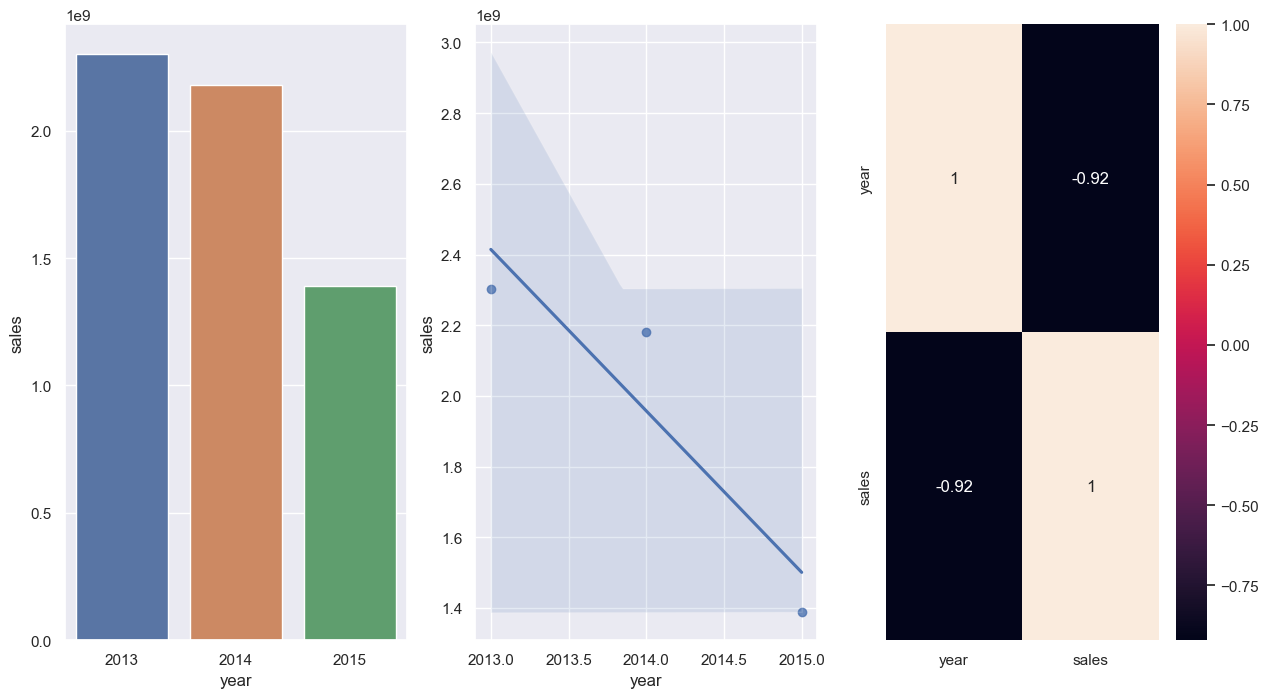

In [49]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 10. Lojas deveriam vender mais no segundo semestre do ano.
#### FALSA Lojas vendem menos no segundo semestre do ano.

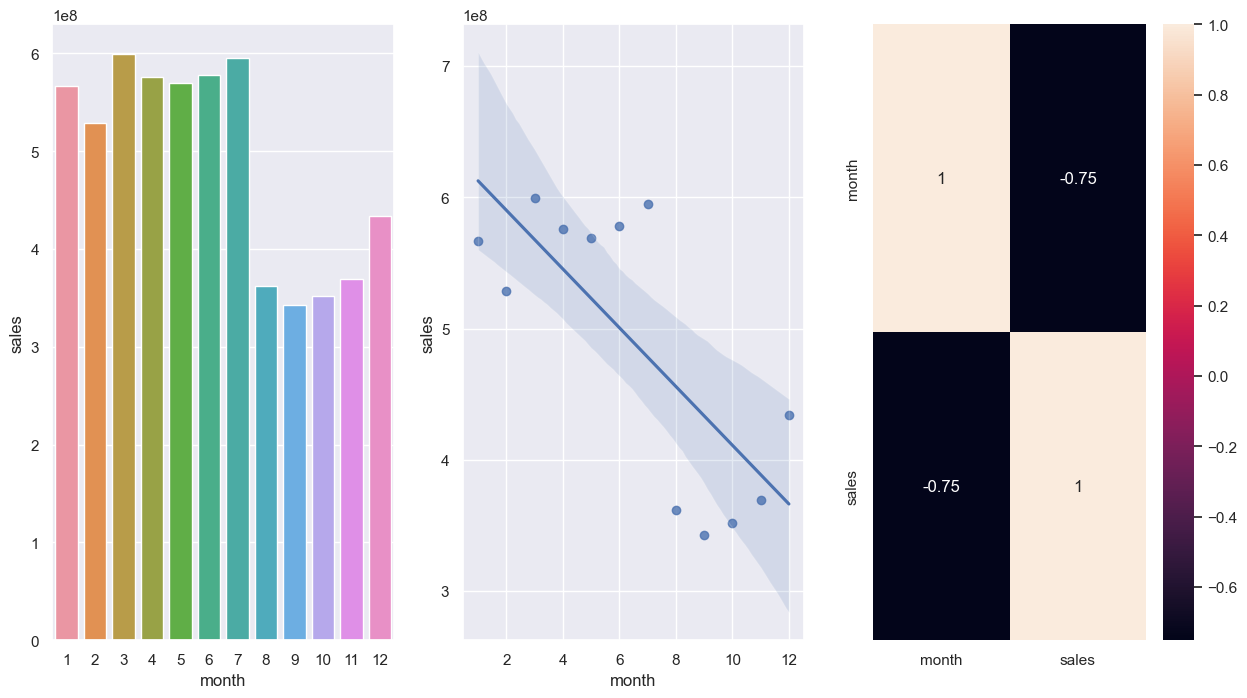

In [50]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 11. Lojas deveriam vender mais depois do dia 10 de cada mês.
#### VERDADEIRA Lojas vendem mais depois do dia 10 de cada mes

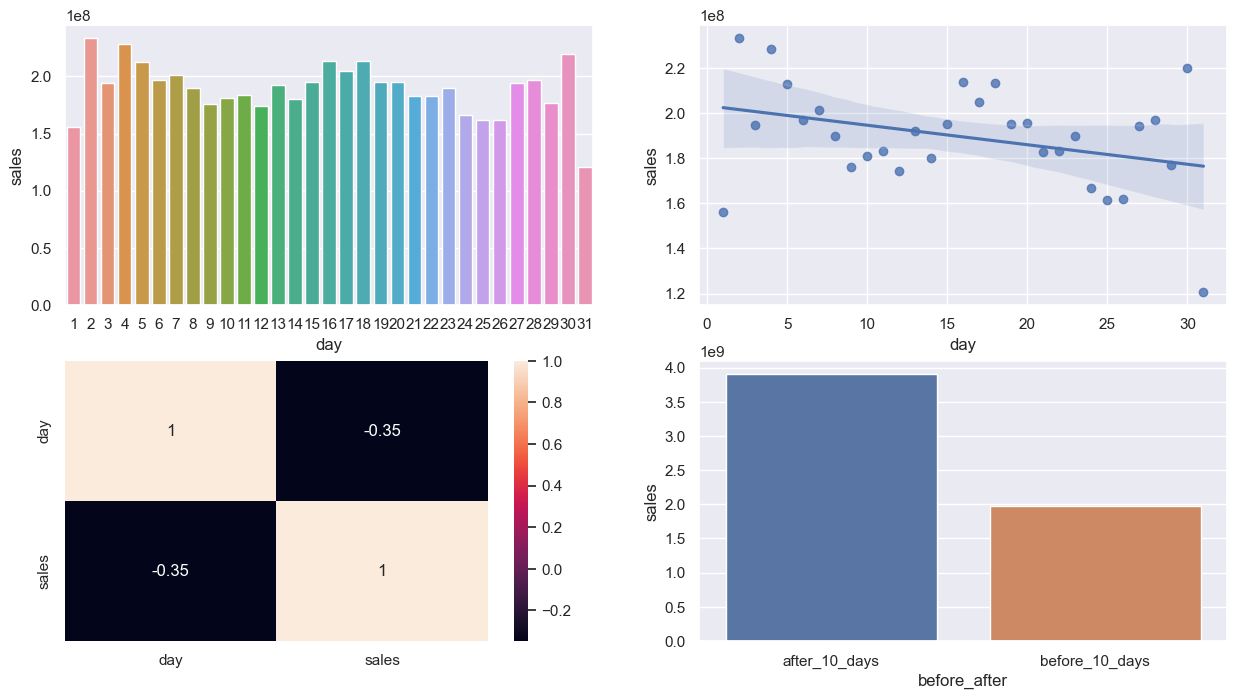

In [51]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### 12. Lojas deveriam vender menos aos finais de semana.
#### VERDADEIRA Lojas vendem menos nos final de semana

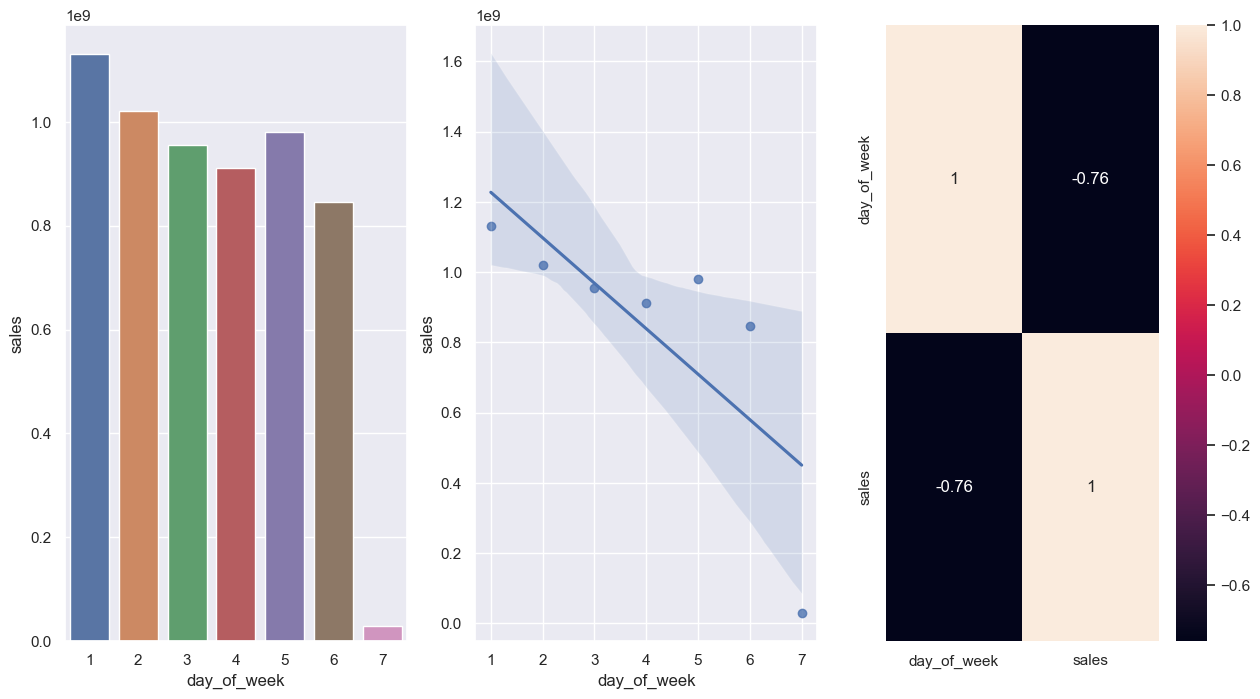

In [52]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 13. Lojas deveriam vender menos durante os feriados escolares.
#### VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

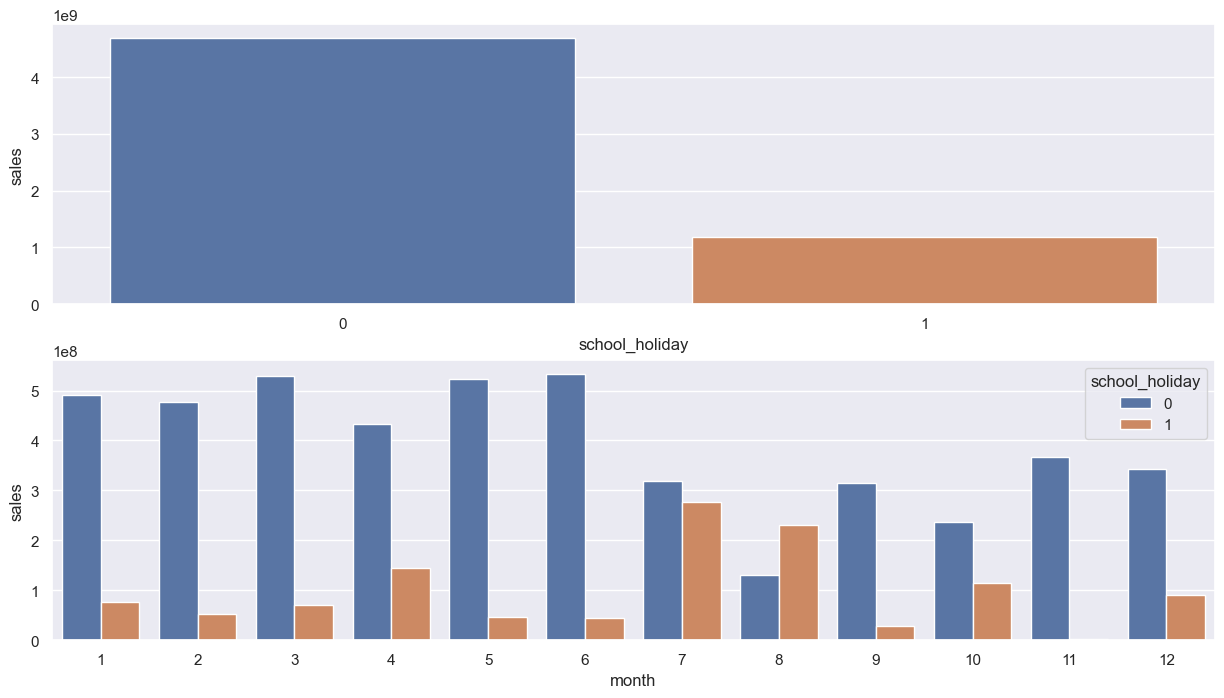

In [53]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

In [54]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.2 Numerical Variable

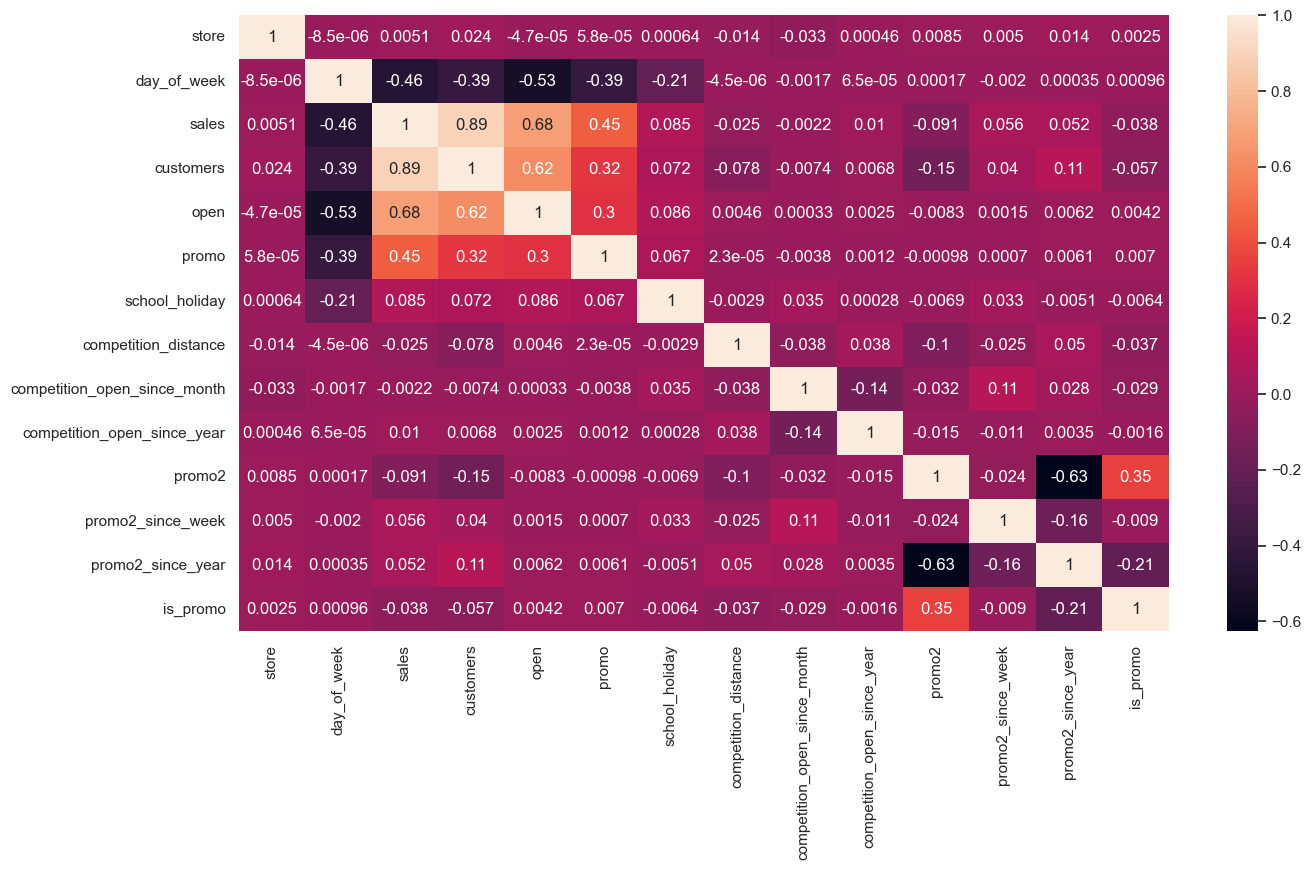

In [55]:
sns.heatmap(num_atributes.corr(method = 'pearson'), annot = True);

### 4.3.3 Categorical Variable

In [56]:
a = df4.select_dtypes(include = 'object')

In [57]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### GERANDO A FÓRMULA CRAMER V

In [58]:
cm = pd.crosstab(a['state_holiday'], a['store_type'])
cm

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [59]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).values
cm

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [60]:
chi2 = ss.chi2_contingency(cm)
chi2

(12792.159524019908,
 0.0,
 9,
 array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
        [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
        [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
        [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

In [61]:
n = cm.sum()
r, k = cm.shape
print(n)
print(r)
print(k)

844338
4
4


In [62]:
chi2 = chi2[0]
chi2

12792.159524019908

In [63]:
v = np.sqrt((chi2/n) / (min(k-1, r-1)))
v

0.07106457093267678

#### GERANDO A CORRELAÇÃO

<AxesSubplot:>

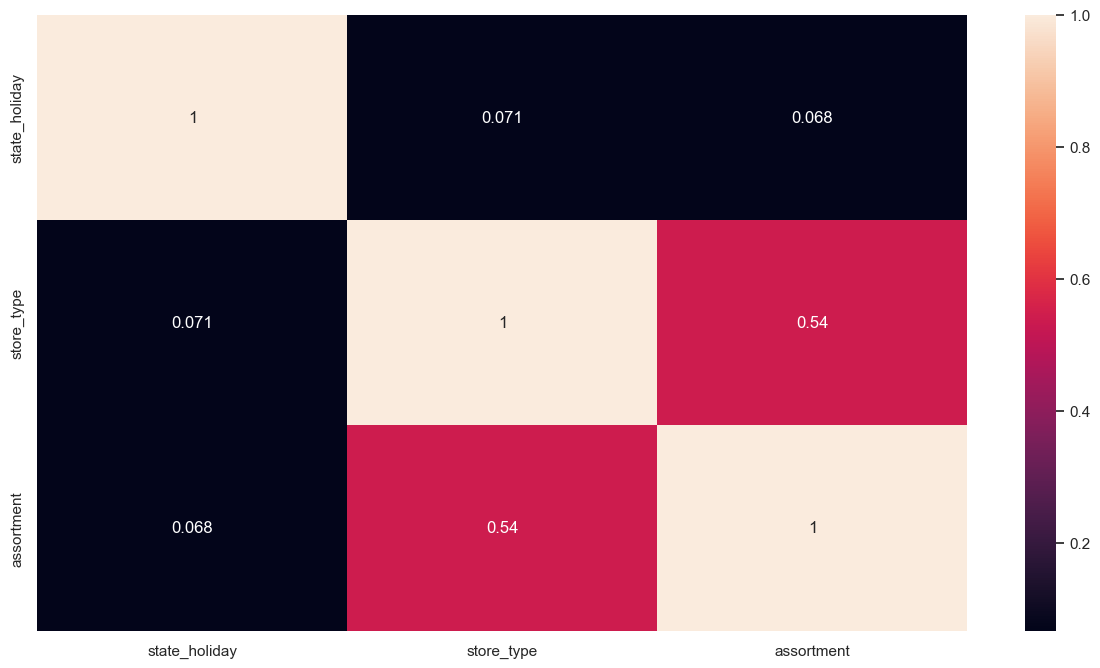

In [64]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 Data Preparation

In [65]:
df5 = df4.copy()
df5

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## 5.1 Normalização

## 5.2 Reescaling

In [66]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

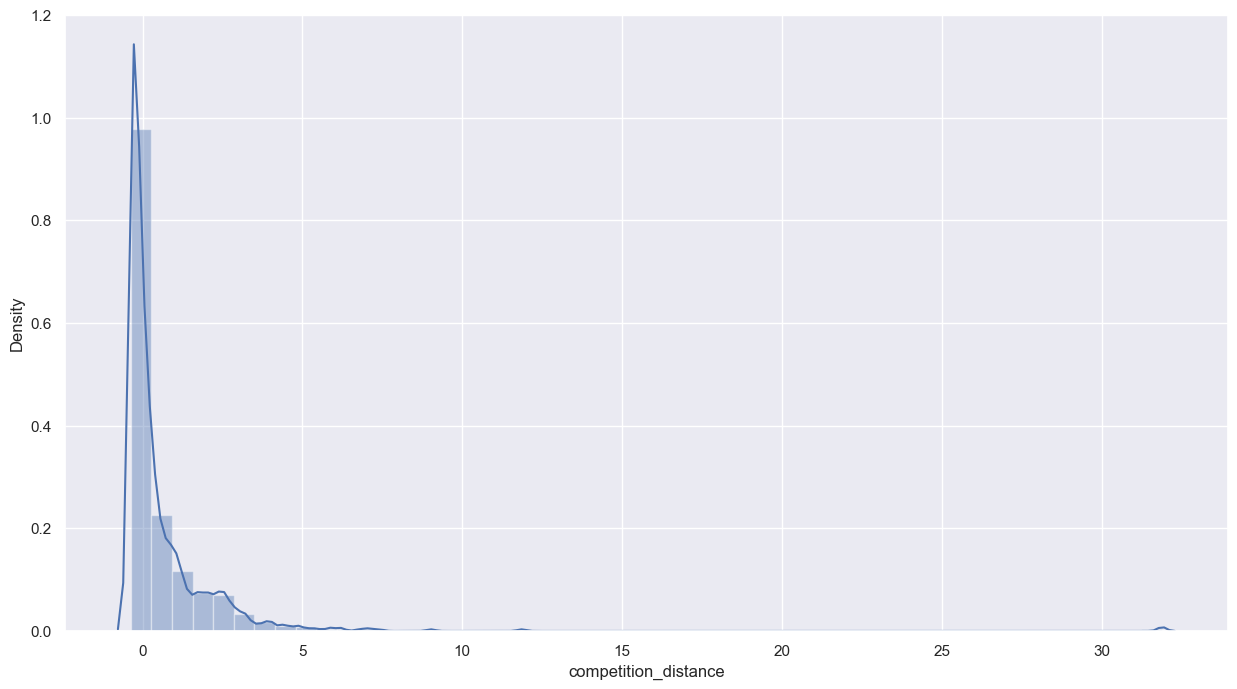

In [67]:
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

#### 5.3.1 Encoding

In [68]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [69]:
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,1,1,1,-0.351613,9,...,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016,0,0,1,0
1016827,733,2,2013-01-01,10765,0,1,1,2,-0.237097,10,...,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016,0,0,1,0
1016863,769,2,2013-01-01,5035,0,1,1,2,-0.240323,1,...,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683,0,0,1,0
1017042,948,2,2013-01-01,4491,0,1,1,2,-0.145161,1,...,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016,0,0,1,0


#### 5.3.2 Response Transformation

In [70]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3 Transformação de natureza (aquelas cíclicas)

In [71]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. *np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. *np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * ( 2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * ( 2. * np.pi/30 )))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2.* np.pi/52 )))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2.* np.pi/52 )))

In [72]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selector

In [73]:
df6 = df5.copy()

In [74]:
df6 = df6.drop(['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week'],axis = 1)

## 6.1 Separando Treino e teste

In [75]:
#últimas 6 semanas serão teste
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7)

#train
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#test
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

## 6.2 Boruta selector (selecionando as features pelo boruta)

In [76]:
# trining and test dataset
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
Y_train_n= Y_train.values.ravel()

#define RandomForest
rf = RandomForestRegressor(n_jobs = -1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, Y_train_n)

In [77]:
#cols_selected = boruta.support_.tolist()
#
##best selected
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
##not selexted boruta
#cols_not_selected = #list(np.setdiff1d(X_train_fs.columns, #cols_selected_boruta))

In [78]:
cols_not_selected

NameError: name 'cols_not_selected' is not defined

In [79]:
cols_selected_boruta

NameError: name 'cols_selected_boruta' is not defined

In [80]:
tab

[['Hipoteses', 'Conclusao', 'Relevancia'],
 ['H1', 'Falsa', 'Baixa'],
 ['H2', 'Falsa', 'Media'],
 ['H3', 'Falsa', 'Media'],
 ['H4', 'Falsa', 'Baixa'],
 ['H5', '-', '-'],
 ['H7', 'Falsa', 'Baixa'],
 ['H8', 'Falsa', 'Media'],
 ['H9', 'Falsa', 'Alta'],
 ['H10', 'Falsa', 'Alta'],
 ['H11', 'Verdadeira', 'Alta'],
 ['H12', 'Verdadeira', 'Alta'],
 ['H13', 'Verdadeira', 'Baixa']]

In [81]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [82]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

# 7.0 Machine Learning Modelling

In [83]:
#para o treinamento normal
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [84]:
#para o crossvalidation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [85]:
aux1 = x_test.copy()
aux1['sales']  = Y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'prediction'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['prediction']

#performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
## model
#lr = LinearRegression().fit(x_train, Y_train)
#
#
## prediction
#yhat_lr = lr.predict(x_test)
#
#
## performance
#lr_result = ml_error('Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr))
#lr_result

### 7.2.1 Liner Regression Model - Crossvalidated

In [88]:
#lr_result_cv = crossvalidation(x_training, kfold = 5, model_name = 'Linear Regression', model = LinearRegression())
#lr_result_cv

## 7.3 Liner Regression Regularized Model - Singular

In [89]:
from sklearn.linear_model import Lasso

In [90]:
##model
#lrr = Lasso(alpha = 0.01).fit(x_train, Y_train)
#
#
##prediction
#yhat_lrr = lrr.predict(x_test)
#
#
##performance
#lrr_result = ml_error('Linear Regression Regularized', np.expm1(Y_test), np.expm1(yhat_lrr))
#lrr_result

### 7.3.1 Liner Regression Regularized Model - Crosvalidated

In [91]:
#lrr_result_cv = crossvalidation(x_training, kfold = 5, model_name = 'Linear Regression Regularized', model = Lasso(alpha = 0.01))
#lrr_result_cv

## 7.4 RandomForest

In [92]:
from sklearn.ensemble import RandomForestRegressor

In [93]:
##model
#rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, Y_train)
#
#
##prediction
#yhat_rf = rf.predict(x_test)
#
#
##performance
#rf_result = ml_error('Random Forest', np.expm1(Y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1 RandomForest - Crossvalidated

In [94]:
#rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, Y_train)
#rf_result_cv = crossvalidation(x_training, kfold = 5, model_name = 'Random Forest', model = rf)
#rf_result_cv

## 7.5 XGBoost Regressor

In [95]:
import xgboost as xgb

In [96]:
##model
#model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                             n_estimators = 100,
#                             eta = 0.01,
#                             max_depth = 10,
#                             subsample = 0.7,
#                             colsample_bytree = 0.9).fit(x_train, Y_train)
#
#
##prediction
#yhat_xgb = model_xgb.predict(x_test)
#
#
##performance
#xgb_result = ml_error('XGBoost Forest Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.5.1 XGBoost Regressos - Crossvalidated

In [97]:
#model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                             n_estimators = 100,
#                             eta = 0.01,
#                             max_depth = 10,
#                             subsample = 0.7,
#                             colsample_bytree = 0.9).fit(x_train, Y_train)
#xgb_result_cv = crossvalidation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#xgb_result_cv

In [98]:
#modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result.sort_values('RMSE_CV')

# 8.0 Fine Tuning

## 8.1 Random Search

In [99]:
#param = {'n_estimators': [15, 17, 25, 30, 35],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]}
#
#MAX_EVAL = 2

In [101]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    
#    #model
#    #já treinei ele lá em cima então remove o fit
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])
#    
#    #performance
#    result = crossvalidation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#
#final_result

## 8.2 Final Model

In [102]:
param_tuned = {'n_estimators': 30,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.7,
               'min_child_weight': 15}

In [104]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = param_tuned['n_estimators'],
                             eta = param_tuned['eta'],
                             max_depth = param_tuned['max_depth'],
                             subsample = param_tuned['subsample'],
                             colsample_bytree = param_tuned['colsample_bytree'],
                             min_child_weight = param_tuned['min_child_weight']).fit(x_train, Y_train)


#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


#performance
xgb_result_tuned = ml_error('XGBoost Forest Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Forest Regressor,6763.335122,0.9617,7411.045287


# 9.0 Error Interpretation

In [105]:
df9 = X_test[cols_selected_boruta_full]
# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [118]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

In [116]:
# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})
df9_aux2

,store,MAPE
0,1,0.946598
1,2,0.953749
2,3,0.966146
3,4,0.974968
4,5,0.949230
...,...,...
1110,1111,0.949652
1111,1112,0.970600
1112,1113,0.962891
1113,1114,0.987817


In [108]:
# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

In [115]:
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]
df92

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,8557.363281,4401.616354,12713.110208,4155.746927,0.946598
1,2,8007.099609,3279.291492,12734.907727,4727.808117,0.953749
2,3,8227.753906,1580.125634,14875.382178,6647.628272,0.966146
3,4,9064.480469,-673.722766,18802.683703,9738.203235,0.974968
4,5,7782.665527,3482.061896,12083.269159,4300.603632,0.949230
...,...,...,...,...,...,...
1110,1111,8050.834473,3569.667840,12532.001105,4481.166633,0.949652
1111,1112,8943.409180,557.095905,17329.722454,8386.313274,0.970600
1112,1113,8841.003906,2500.841845,15181.165968,6340.162062,0.962891
1113,1114,10073.436523,-12430.632749,32577.505796,22504.069272,0.987817


In [110]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
816,817,8820.053711,-11801.242137,29441.349559,20621.295848,0.988246
1113,1114,10073.436523,-12430.632749,32577.505796,22504.069272,0.987817
841,842,9063.989258,-11061.227256,29189.205772,20125.216514,0.987709
261,262,10997.367188,-9938.414979,31933.149354,20935.782167,0.987540
697,698,8598.265625,-7975.024501,25171.555751,16573.290126,0.986002


<AxesSubplot:xlabel='store', ylabel='MAPE'>

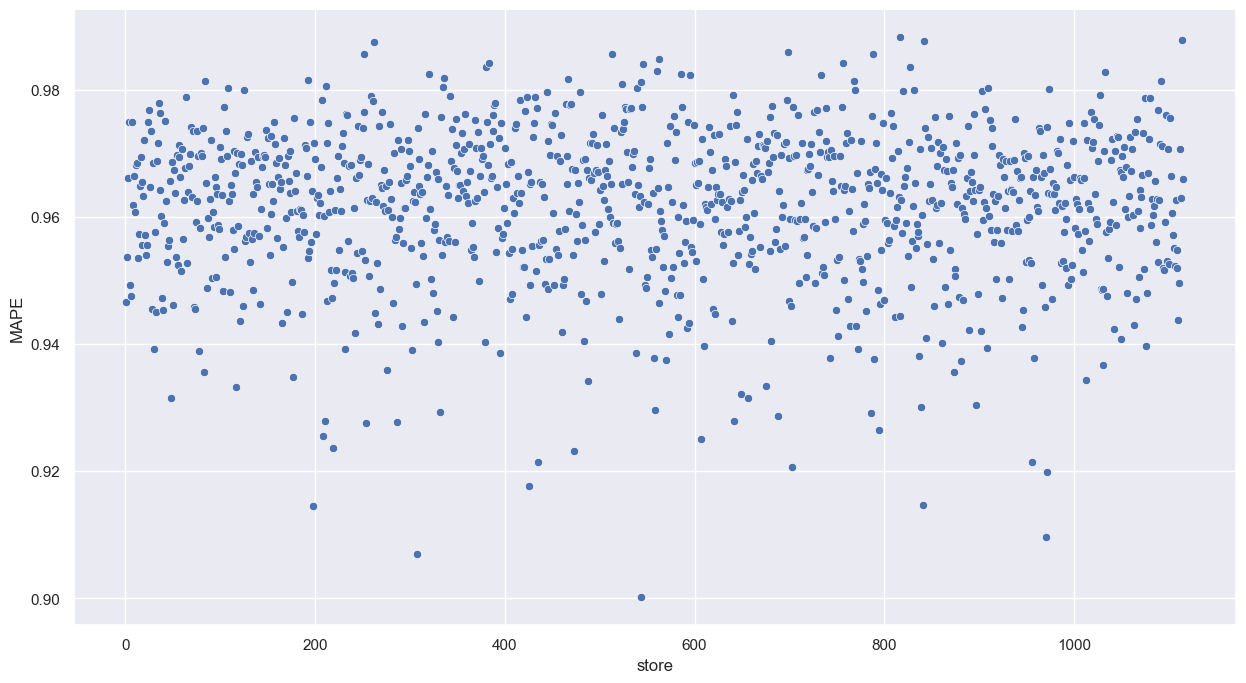

In [111]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [112]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x : np.sum( x ), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$9,596,729.00"
1,worst_scenario,"R$2,062,928.17"
2,best_scenario,"R$17,130,530.42"


## 9.3 ML Performance

In [113]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

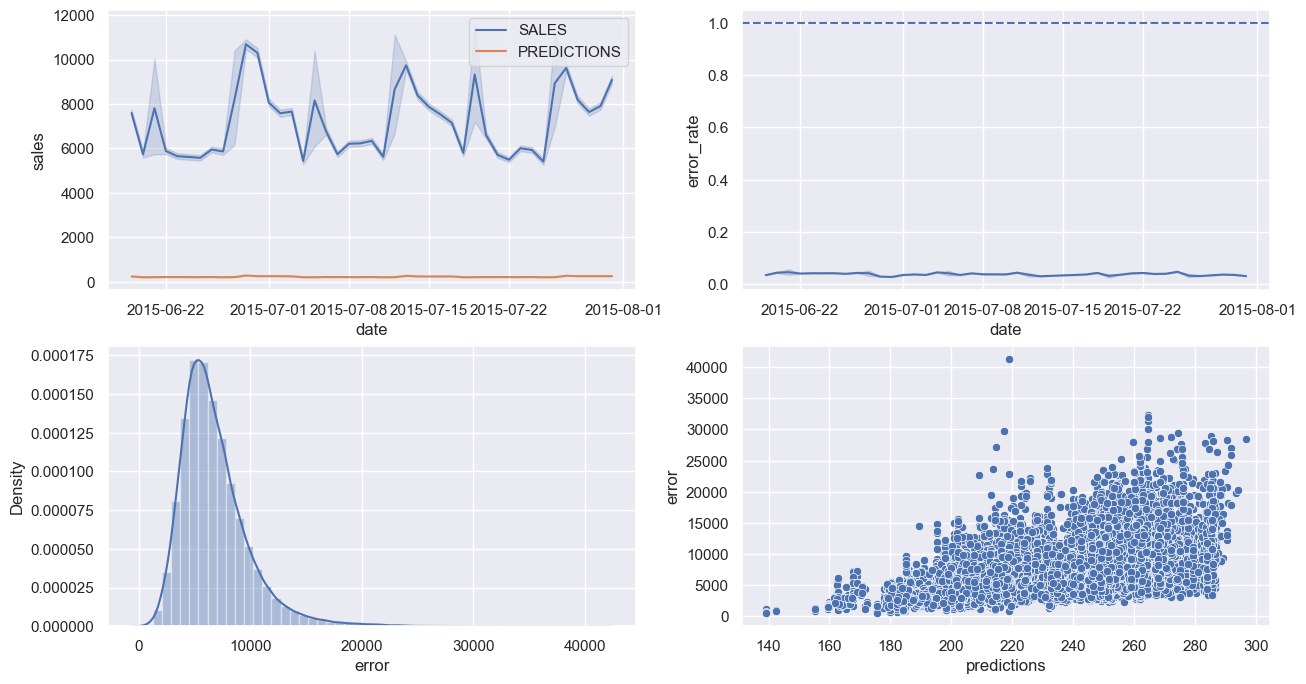

In [114]:
plt.subplot( 2, 2, 1 )
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4 )
sns.scatterplot(df9['predictions'], df9['error'])